## [BEACO2N] Exploring Environmental Data for Schools in Downtown Los Angeles
<br>

**Estimated Time:** 30-45 minutes <br>
**Notebook Developed By:** Lan Dinh <br>

Welcome! This notebook will provide an introduction to environmental data for schools in Los Angeles. Specifically, we will look at two measurements, CO2 and PM2.5, to analyze their trends and patterns throughout year 2023 in Southern California. You won't have to be answering any coding questions yourself in the notebooks for this class, but instead you'll be asked to answer some short-answer questions as we explore and visualize the data. Any questions you see in **yellow-shaded sections** below are questions you'll be answering! Additionally, there will be some optional questions in **blue-shade sections** that help you follow along the notebook and understand the context. We hope this notebook serves as an engaging and informative introduction to the critical role of data collection in studying air quality.

### Learning Outcomes

In this notebook, you will learn about:
- What BEACO2N is and how we use the data to study air quality
- How PM2.5 and CO2 concentrations in downtown Los Angeles change throughout the year

### Table of Contents
1. Background: Emissions and Atmosphere <br>
1. Preview
>2.1 Introduction to BEACON2N
<br>2.2 Schools in downtown Los Angeles <br>
1. Exploring Data <br>
1. Visualizing and Understanding Trends <br>
>4.1 Analyze CO2 Measurements
<br>4.2 (Optional) Interactive Visualization <br>

As some quick reminders, you will not be expected or required to do any coding yourself in this notebook! The only questions you will be answering are some short-answer questions based on the data and visualizations. These questions that you will be answering are located in the yellow-shaded boxes throughout the notebook. Along with this, for any code cells that say "`## Run this cell`" at the top, be sure to run them so you can properly see the data tables and visualizations!

**Note: To run a cell, first move your cursor over it and click once. After that, press `Ctrl + Enter` on your keyboard.**

------------------
## Run the cell below to import all our required materials for this notebook!

In [1]:
## Run this cell

# Used for visualizations and interactions
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

# Numerical computation
import numpy as np
from numpy import NaN
from decimal import Decimal

# Manipulating data in form of series or dataframes
import pandas as pd

# Manipulating fields that are date or time
import datetime
from datetime import time

-------------
# 1. Emissions and Atmosphere<a id='0'></a>

**Emissions** are gases and particles that are released into the air. They can come from a variety of sources, including cars, factories, power plants, and even natural sources like volcanoes. When we talk about emissions, we're often talking about greenhouse gas emissions. These are gases like carbon dioxide, methane, and nitrous oxide that trap heat in the Earth's atmosphere and contribute to global warming and climate change. Given the current concerns regarding Global warming and we need to acknowledge that every year around 10 Gigatons of carbon (that’s 10 x 109 tons of carbon per year, written as GtC/yr) is emitted by combustion of fossil fuels, which has devastating enviornmental effects.

The **Atmospere** is a layer of gas that surrounds the Earth. It's made up of different gases, including nitrogen, oxygen, and a small amount of other gases like carbon dioxide and methane. Understanding its impact is super important because it protects us from harmful radiation from the sun and helps regulate the temperature of the Earth. It's kind of like a blanket that keeps the Earth warm and cozy.

**Data Analytics** plays a important role in answering questions like, what is the trend in carbon dioxide emission throughout a year?


<!-- BEGIN QUESTION -->
<div class="alert alert-warning">

## Question 1:

**How can we as individuals reduce our personal emissions, and what are some practical steps we can take to make a positive impact on the environment?**
</div>

*Type your answer here. Double-click to edit this cell and replace this text with your answer. Run this cell to proceed when finished.*

-------------
# 2. Preview<a id='0'></a>


### 2.1. Introduction to BEACO2N <a id='0'></a>

*What is BEACO2N?*

BEACO2N provides a new strategy for understanding greenhouse gases (GHGs) and air quality at street level in near real time. This gives pedestrians, companies, and policy-makers unique insights into their GHG emissions and air quality experiences.

Through the low cost sensor network, BEACO2N is able to create a **highly detailed map** of CO2 and pollutants in our air. The data provides a clear route to **evaluating the effectiveness of local and regional efforts** to reduce GHG emissions, improve air quality, improve environmental equity, and reduce the detrimental effects of emissions on public health.

*Data Collection*

The BEACO2N network deploys low-cost air quality sensors -- called **"nodes"** --  approximately 1 mile (2km) apart from each other to measure 6 different pollutants (**CO2, NO, NO2, O3, CO, and aerosol**). The nodes sample air every minute of the day. Data from these sensors are collected once **every five seconds** onto a miniature computer which then sends the data to a centralized server, which makes the data available in near real time.

Although the individual nodes are less precise than the highly sensitive traditional sensors, when working as part of a network, the nodes create a highly detailed map of CO2 and other pollutants in our air.

Feel free to check out the [website](https://beacon.berkeley.edu/about/) for more information about how BEACO2N works, cool visulizations, and data.

<figure>
    <img src="./b.png" alt="An image" width=600 height=400 />
    </figure>

### 2.2. Schools in downtown Los Angeles <a id='0'></a>

In this notebook, we will leverage the nodes from BEACO2N to investigate air quality in downtown Los Angeles. The upcoming cells will extract data to identify the schools we will be examining.

In [26]:
## Run this cell

# Load the data from get_latest_nodes.csv into a Pandas DataFrame
file_name = "./beacon-mapping-files-main/get_latest_nodes.csv"
data = pd.read_csv(file_name, on_bad_lines='skip')
# Clean up data
data = data.replace({-999:np.NAN})
data = data.replace({-111:np.NAN})

# Nodes of schools in Los Angeles
data_filtered = data[data["groups"]=="['USC']"][['id','node_name_long', 'groups']]\
                      .rename(columns={"id": 'node_id', "node_name_long": "school"})
names = data_filtered.groupby('node_id', group_keys=False)[['node_id','school']].apply(lambda x: x)\
                      .set_index('node_id').drop(index=[206, 208, 210, 212, 216, 220])
names

,school
node_id,
207,Castelar Elementary School
209,Wilshire Crest Elementary School
211,Tenth Street Elementary School
213,Dorsey High School
215,Foshay Learning Center
217,Murchison Street Elementary School


Once you run the above code, a table displaying schools will appear. Observe that the first column lists the node IDs, while the second column provides the names of these schools.

<div class=" alert alert-info">

## Optional Question:
Use Google Map to locate one or more schools in the table above. How close are they to El Camino College?

</div> 

-------------
# 3. Exploring Data<a id='0'></a>


Before we begin our analysis, we first need to obtain 2022 data from the BEACO2N website for these LA schools. The following cell includes functions for data extraction and storage in tables. 

**Note: It's okay if the code seems complex; you're not required to grasp all the details.** 

In [27]:
## Run this cell

# Function to pull in data from BEACO2N website
def pull_data(parameter, start, end, *nodes):
    full = pd.DataFrame()
    for node in nodes:
        filename = 'http://128.32.208.8/node/' + node + '/measurements_all/csv?name=Supersite&interval=60&variables=' + parameter + '&start=' + start + '&end=' + end
        data = pd.read_csv(filename, on_bad_lines='skip', index_col=[0], parse_dates=[0])
        data = data.rename(columns={parameter:node})
        data = data.drop(['epoch','node_id','node_file_id','datetime'], axis=1)
        full = pd.merge(full, data, how='outer', left_index=True, right_index=True)
    return full

# .drop(index=[206, 210, 212, 215, 216])
# Function to store data
def store_data():
    parameters = ['co2_corrected_avg_t_drift_applied-level-2', 
                  'pm2_5',
                  # 'no2_corrected_new_no_negatives',
                  # 'no_corrected_new_no_negatives'
                 ]
    start = '2022-01-01%2000:00:00'
    end = '2022-12-31%2000:00:00'
    df_lst = []
    for parameter in parameters:
        df = pull_data(parameter, start, end, '207', '209', '211', '213', '215', '217')
        df_lst.append(df)
    print('Complete!')
    return df_lst

# Function to pre-process data
def clean(data):
    # Replace misisng data
    data = data.replace({-999:np.NAN})
    data = data.replace({-111:np.NAN})
    # Change columns name from node_id to name of school
    nodes = np.array(names.index.astype(str))
    schools = np.array(names['school'])
    renames = {}
    for node, school in zip(nodes, schools):
      renames[node] = school
    data = data.rename(columns=renames)
    #Aggregate over schools per timestep
    data['average'] = data.quantile(q=0.5, axis=1, numeric_only=True, interpolation='linear')
    # Add month information
    month_names = {1: 'January', 2: 'February', 3: 'March',
               4: 'April',5: 'May', 6: 'June', 7: 'July',
               8: 'August', 9: 'September', 10: 'October',
               11: 'November', 12: 'December'}
    data['month'] = data.index.month
    data['month'] = data['month'].replace(month_names)
    # Add day_of_week information
    data['day_of_week'] = data.index.day_name()
    # Add hour information
    data['hour'] = data.index.time
    return data

<div class="alert alert-danger">

### Warning:
### The cell below will take around 5-10 minutes to complete 
### Upon successful execution, the code will generate the message "Complete!"

</div>

Run the cell below to call store our data into tables. We will be working with two separate tables for CO2 and PM2.5 measurements. Please note that running this cell may take some time.

In [28]:
## Run this cell
# Pull in and store CO2, PM2_5, NO, and NO2 data
# This cell will take around 5-10 minutes
# Upon successful excecution, the code will generate the messafe "Complete!"
dfs = store_data()
CO2_vals, PM_2_5_vals = clean(dfs[0]), clean(dfs[1])

Complete!


After the cell above displays the `'Complete!'` message, we'll take a closer look at these tables. The first code cell will produce a table for CO2 measurements across LA schools, and the second cell will create a table for PM2.5 measurements across LA schools.

In [29]:
## Run this cell
# Display CO2 table
CO2_vals.head(5)

,Castelar Elementary School,Wilshire Crest Elementary School,Tenth Street Elementary School,Dorsey High School,Foshay Learning Center,Murchison Street Elementary School,average,month,day_of_week,hour
local_timestamp,,,,,,,,,,
2022-01-01 00:00:00,474.394811,454.754815,479.323818,457.456346,512.986119,495.927671,476.859314,January,Saturday,00:00:00
2022-01-01 01:00:00,458.529919,472.803359,463.466288,467.672206,486.118166,501.836784,470.237783,January,Saturday,01:00:00
2022-01-01 02:00:00,446.704887,474.367161,457.190809,478.979699,488.544615,501.910615,476.673430,January,Saturday,02:00:00
2022-01-01 03:00:00,445.257503,441.308370,461.711180,470.076929,517.923216,493.854063,465.894054,January,Saturday,03:00:00
2022-01-01 04:00:00,451.236694,442.691714,462.355391,472.224437,502.656364,471.567216,466.961304,January,Saturday,04:00:00


In [6]:
## Run this cell
# Display PM_2_5 table
PM_2_5_vals.head(5)

,Castelar Elementary School,Pio Pico Middle School,Wilshire Crest Elementary School,Tenth Street Elementary School,Dorsey High School,Foshay Learning Center,Murchison Street Elementary School,Third Street Elementary School,average,month,day_of_week,hour
local_timestamp,,,,,,,,,,,,
2022-01-01 00:00:00,26.54374,NaN,12.29929,92.05060,32.18571,85.34532,53.26366,14.62857,32.185710,January,Saturday,00:00:00
2022-01-01 01:00:00,24.53191,NaN,19.20000,35.32458,35.49517,56.09639,50.62322,NaN,35.409875,January,Saturday,01:00:00
2022-01-01 02:00:00,17.08768,NaN,23.06444,29.85782,33.55048,42.02153,44.62053,NaN,31.704150,January,Saturday,02:00:00
2022-01-01 03:00:00,18.57920,NaN,10.20952,30.54137,23.85919,50.22356,38.95444,19.49289,23.859190,January,Saturday,03:00:00
2022-01-01 04:00:00,15.77358,NaN,5.20331,29.68000,20.20665,36.90215,21.51185,5.56808,20.206650,January,Saturday,04:00:00


When working with large datasets, it's helpful to examine statistical number to have an overview of our data's characteristics. The following cell will produce a table displaying eight statistical measures for CO2 concentration values across LA schools in 2022: count (number of observations, mean, standard deviation, minimum, 25th percentule, 50th percentile, 75th percentile, and maximum.

In [30]:
## Run this cell
# Statistics of CO2 concentration across LA schools in 2022
CO2_vals.describe()

,Castelar Elementary School,Wilshire Crest Elementary School,Tenth Street Elementary School,Dorsey High School,Foshay Learning Center,Murchison Street Elementary School,average
count,8798.000000,8789.000000,4752.000000,8798.000000,8798.000000,8706.000000,8799.000000
mean,459.037792,462.091685,456.741034,464.609944,466.062884,453.742564,460.170820
std,32.799002,46.009444,33.541607,51.084655,53.952285,26.540267,39.327977
min,413.472309,416.279029,395.492376,395.585932,415.086652,415.338667,416.568521
25%,436.088673,431.389615,434.406622,432.770744,433.771296,434.503934,434.088924
50%,447.659079,442.621685,446.705207,442.875201,444.708469,445.247939,444.799712
75%,473.841717,475.391010,467.710525,475.997093,473.837259,466.630235,472.718961
max,621.211308,727.916350,676.127585,775.151288,827.848067,615.807408,717.855490


<!-- BEGIN QUESTION -->
<div class="alert alert-warning">

## Question 2:

**What are your observations regarding the CO2 concentraion values across these school? Consider what the data reveals about CO2 concentrations in the area where these schools located, differences among them and what might account for these differences.**
</div>

*Type your answer here. Double-click to edit this cell and replace this text with your answer. Run this cell to proceed when finished.*

-------------
# 4. Visualizing and Understanding Trends<a id='0'></a>

### 4.1. Analyze CO2 Measurements

A limitation of using statistical summaries is their inability to show data trends over time. In this section, we aim to delve deeper through visualization to uncover more insights. Just like before, we need to start by defining some functions that will enable us to create the plots. Remember, it's not necessary for you to fully comprehend the code! Just run the cell below.

In [31]:
## Run this cell

# Function to plot one school data over year
def plot_year(data):
    dfs = {'CO2': CO2_vals, 'PM2.5': PM_2_5_vals}
    df = dfs[data]
    plt.figure(figsize=(25,8))
    plt.title(data + ' Measurements across LA Schools in 2022', fontsize=25)
    plt.xlabel('Date', fontsize=25)
    plt.ylabel(data, fontsize=25)
    plt.plot(df['average'].rolling(window=24*14, min_periods=24*6, center=True).mean(), 
             color = 'red', linewidth=5)
    plt.plot(df.index, df['average'], linewidth=0.7)
    plt.show()
    
# Function to plot compare weekends/weekdays data over year
def compare_year(data):
    plt.figure(figsize=(25,8))
    dfs = {'CO2': CO2_vals, 'PM2.5': PM_2_5_vals}
    df = dfs[data]
    df_weekdays = df[(df['day_of_week']=='Monday') |
                    (df['day_of_week']=='Tuesday') | 
                    (df['day_of_week']=='Wednesday') | 
                    (df['day_of_week']=='Thursday') | (df['day_of_week']=='Friday')]
    weekdays = df_weekdays.groupby('hour',group_keys=False).mean(numeric_only = True)
    df_weekends = df[(df['day_of_week']=='Saturday') |(df['day_of_week']=='Sunday')]
    weekends = df_weekends.groupby('hour', group_keys=False).mean(numeric_only = True)
    
    plt.plot(weekdays.index.astype(str), weekdays['average'], label='Weekdays')
    plt.plot(weekends.index.astype(str), weekends['average'], label='Weekends')
    plt.title('Compare ' + data + ' Measurements Betwwen Weekdays and Weekends in 2022', fontsize=25)
    plt.xlabel('Time of Day', fontsize=25)
    plt.ylabel(data, fontsize=25)
    plt.legend(fontsize=16)
    plt.show()

# Function to plot data over a month
def plot_month(data, month):
    plt.figure(figsize=(25,8))
    dfs = {'CO2': CO2_vals, 'PM2.5': PM_2_5_vals}
    df = dfs[data]
    df = df[df['month'] == month]
    plt.title(data + ' Measurements of School accross LA Schools in ' + month, fontsize=25)
    plt.xlabel('Date', fontsize=25)
    plt.ylabel(data, fontsize=25)
    plt.plot(df.index, df['average'])
    plt.show()

# Function to compare weekends/weekdays data over a month
def compare_month(data, month):
    plt.figure(figsize=(25,8))
    dfs = {'CO2': CO2_vals, 'PM2.5': PM_2_5_vals}
    df = dfs[data]
    df = df[df['month'] == month]
    df_weekdays = df[(df['day_of_week']=='Monday') |
                    (df['day_of_week']=='Tuesday') | 
                    (df['day_of_week']=='Wednesday') | 
                    (df['day_of_week']=='Thursday') | (df['day_of_week']=='Friday')]
    weekdays = df_weekdays.groupby('hour',group_keys=False).mean(numeric_only = True)
    df_weekends = df[(df['day_of_week']=='Saturday') |(df['day_of_week']=='Sunday')]
    weekends = df_weekends.groupby('hour', group_keys=False).mean(numeric_only = True)
    plt.plot(weekdays.index.astype(str), weekdays['average'], label='Weekdays')
    plt.plot(weekends.index.astype(str), weekends['average'], label='Weekends')
    plt.title('Compare ' + data + ' Measurements between Weekdays and Weekends in ' + month, fontsize=25)
    plt.xlabel('Time of Day', fontsize=25)
    plt.ylabel(data, fontsize=25)
    plt.legend(fontsize=16)
    plt.show()   

Next, we're going to visualize graphs demonstrating the CO2 measurements across LA schools in 2022 and in January, respectively. Please execute the following cells to produce the graphs.

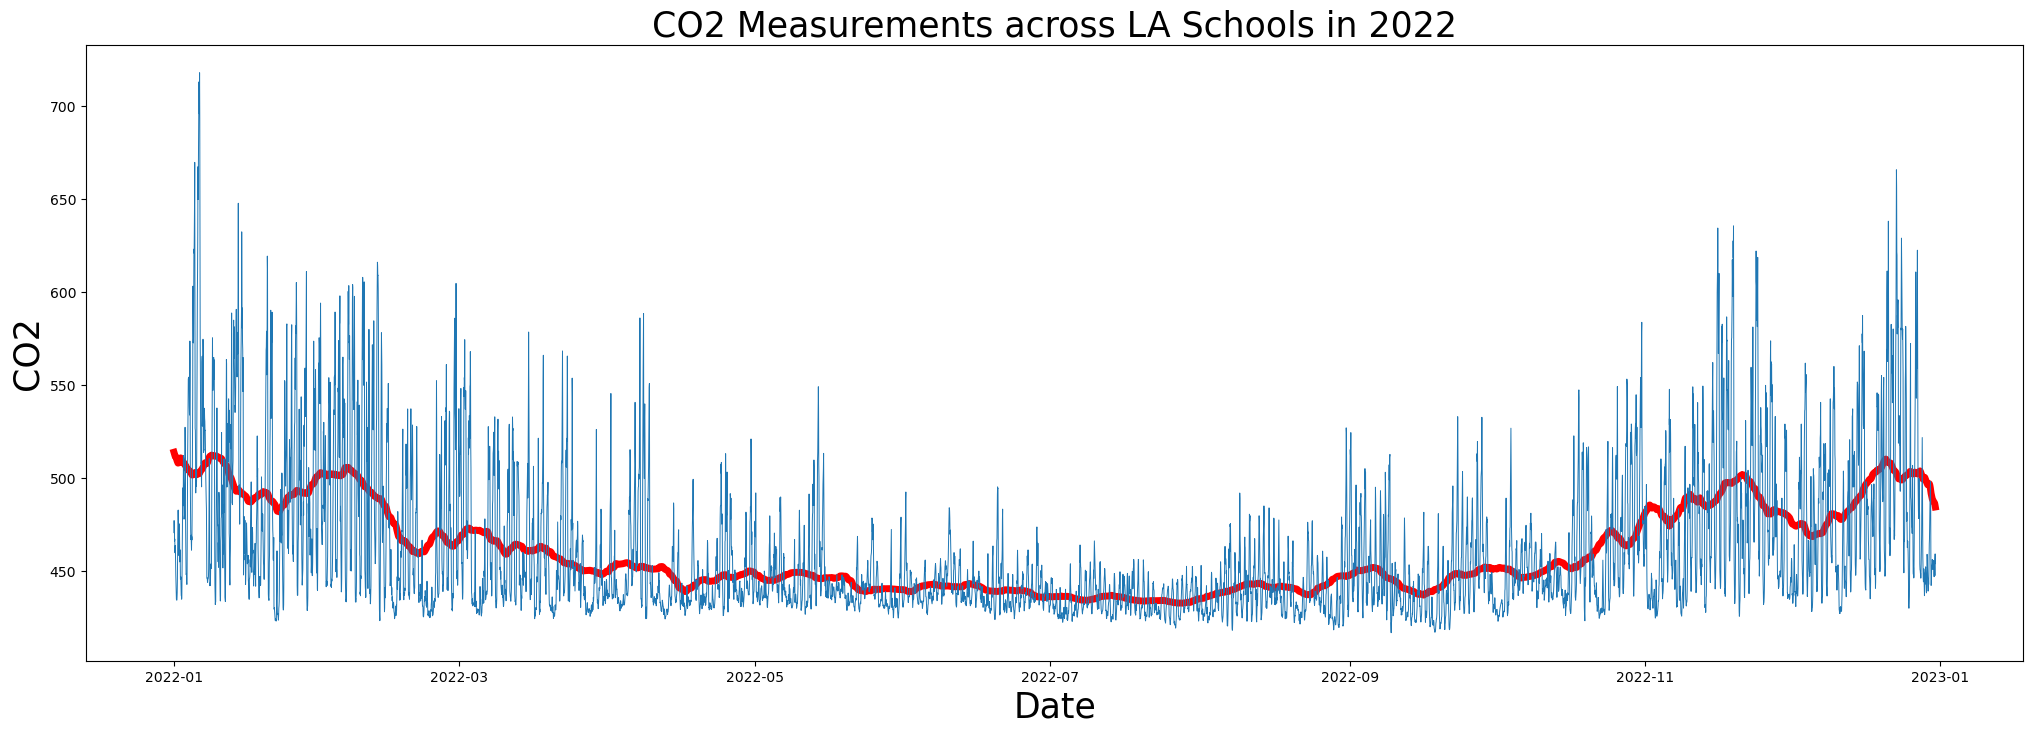

In [32]:
## Run this cell
# Plot CO2 measurements of Castelar Elementary School in 2022
plot_year('CO2')

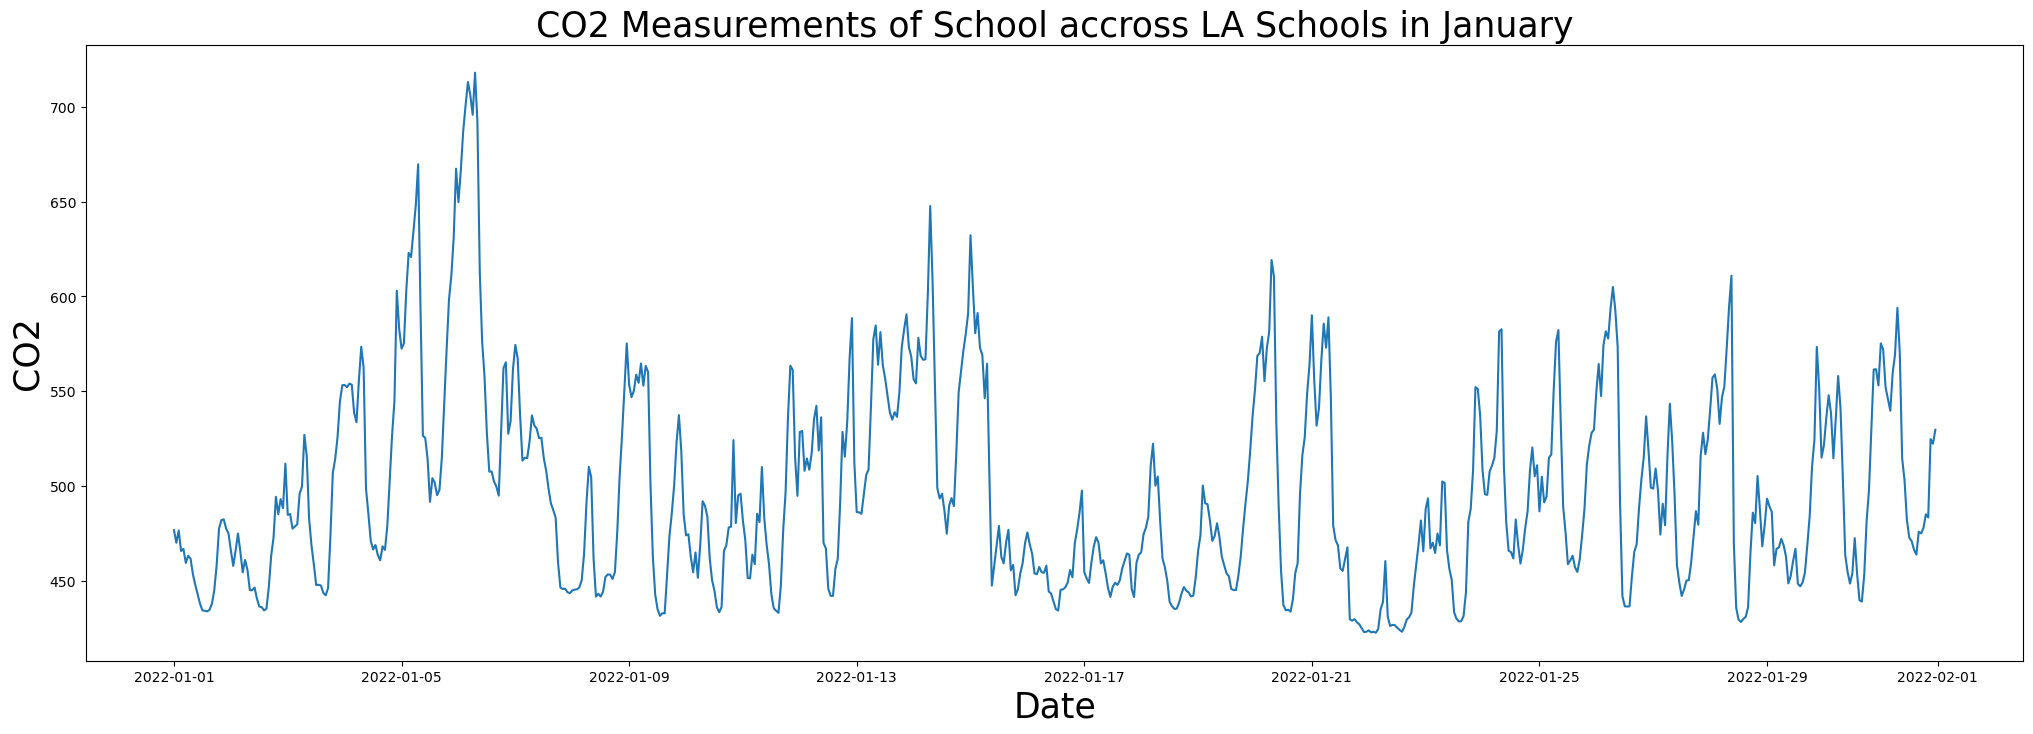

In [33]:
## Run this cell
# Plot CO2 measurements of Castelar Elementary School in January
plot_month('CO2', 'January')

<!-- BEGIN QUESTION -->
<div class="alert alert-warning">

## Question 3:

**Discuss the patterns and trends observed in CO2 measurements throughout 2023 and specifically in January. Among the three analytical approaches: a statistical summary, a yearly line plot, and a monthly line plot, which method would you prefer for examining CO2 levels across LA schools? Consider the specific question you aim to address and decide which approach would best facilitate your analysis.**
</div>

Now, let's delve into something more interesting. One might wonder about the factors affecting CO2 measurements throughout a day. Given our data includes hourly and daily information, we will explore how CO2 levels compare between weekdays and weekends over the course of a day, throughout the year.

Run the cell below to generate a plot of CO2 measurements over the course of a day, categorized by weekends and weekdays.

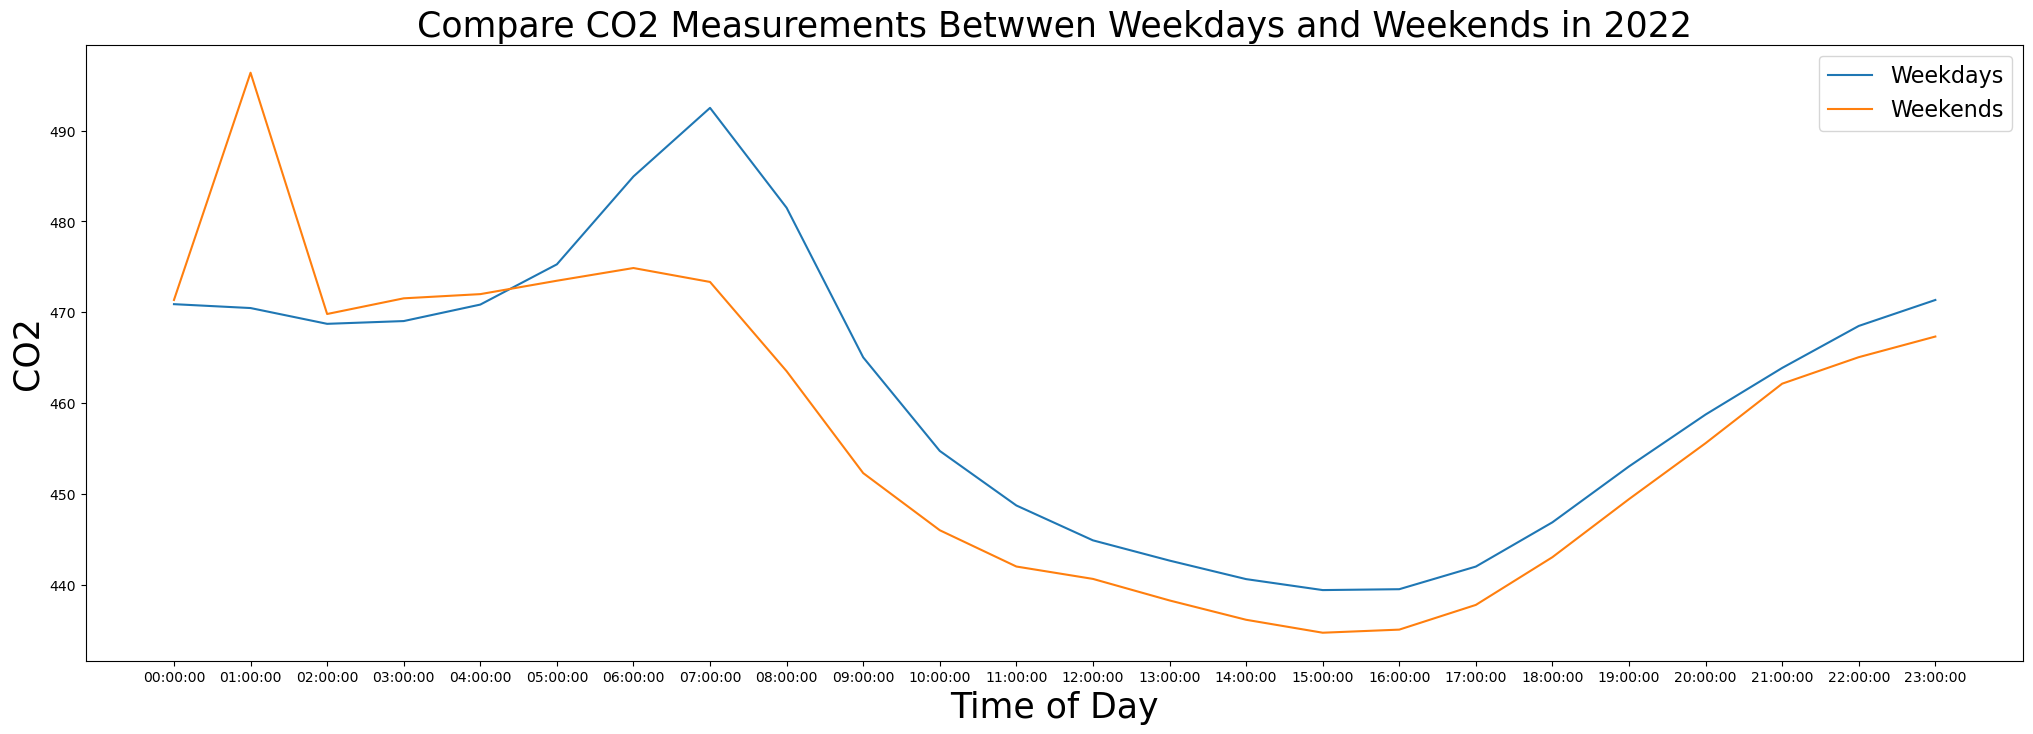

In [34]:
## Run this cell
# Plot CO2 Measurements over hour by weekends/weekdays
compare_year('CO2')

<!-- BEGIN QUESTION -->
<div class="alert alert-warning">

## Question 4:

**Write a few sentences analyzing how days of the week influence the CO2 measurement based on graph produced above.What do you believe are the factors contributing to these differences?**
</div>

### 4.2. (Optional) Interactive Visualization

This section is optional and designed to assist you in exploring various variables from our dataset.
Before each plot, you'll find one or two dropdown menus from which you can select a variable. Once selected, a plot corresponding to your choice will be generated.
In total, there are four plots available in this section:

1. The first plot visualizes your selected measurement (CO2/PM2.5) throughout the year. <br>
1. The second plot displays your selected measurement(CO2/PM2.5) for a specific month. <br>
1. The third plot compares your selected measurement (CO2/PM2.5) between weekdays and weekends over the entire year. <br>
1. The fourth plot compares your selected measurement (CO2/PM2.5) between weekdays and weekends for a particular month. <br>


**Note: Make sure to run the cells sequentially so that it will produce the plot without any errors.**


In [35]:
## Run this cell

#Assign drop down choices for interactive plots
data_dropdown = widgets.Dropdown(
    options =['CO2', 'PM2.5'],
    description ='Data: ',
    disabled = False
)
dropdown_month = widgets.Dropdown(
    options = CO2_vals['month'].unique(),
    description ='Month: ',
    disabled = False
)

In [36]:
## Run this cell
# Plot one school data over a year
interact(plot_year, data=data_dropdown);

interactive(children=(Dropdown(description='Data: ', options=('CO2', 'PM2.5'), value='CO2'), Output()), _dom_c…

In [14]:
## Run this cell
# Plot one school data in a month
interact(plot_month, data=data_dropdown, month=dropdown_month);

interactive(children=(Dropdown(description='Data: ', options=('CO2', 'PM2.5'), value='CO2'), Dropdown(descript…

In [37]:
interact(compare_year, data=data_dropdown);

interactive(children=(Dropdown(description='Data: ', index=1, options=('CO2', 'PM2.5'), value='PM2.5'), Output…

In [16]:
interact(compare_month, data=data_dropdown, month=dropdown_month);

interactive(children=(Dropdown(description='Data: ', options=('CO2', 'PM2.5'), value='CO2'), Dropdown(descript…

<div class=" alert alert-info">

## Optional Question:
Select a measurement (CO2/PM2.5) and a specific month. Use the cells above and the dropdown menu to generate four plots for these two variables. Discuss how this measurement changes over time—both annually and monthly. Analyze the impact of weekends versus weekdays on this measurement throughout the day.

</div> 

-------------
# Congratulations! You Have Completed the Notebook!<a id='0'></a>